In [15]:
import pandas as pd
import numpy as np
import requests
import json
import time
import os 
import gzip
import timeit
import matplotlib.pyplot as plt
from loguru import logger
from sklearn.manifold import TSNE
from scripts.vectology_functions import embed_text, create_aaa_distances
import seaborn as sns

# Apply the default theme
sns.set_theme()

tSNE=TSNE(n_components=2)

cci_df = pd.read_csv('data/CCI-ICD10CM-v2021-1/CCI_ICD10CM_v2021-1.csv',skiprows=2)
cci_df.rename(columns={"'ICD-10-CM CODE DESCRIPTION'":"ICD-10-CM CODE DESCRIPTION","'CHRONIC INDICATOR'":"CHRONIC INDICATOR"},inplace=True)
cci_df['CHRONIC INDICATOR'] = cci_df['CHRONIC INDICATOR'].str.replace("'","")

output='output/disease-cat'

In [4]:
%%time

def make_vectors():
    f = f'{output}/vectors.pickle.gz'
    if os.path.exists(f):
        logger.info(f'{f} exists')
        res_df = pd.read_pickle(f)
    else:
        logger.info(f'\n{cci_df.head()}')
        logger.info(cci_df.shape)

        results=[]
        query_list = list(cci_df['ICD-10-CM CODE DESCRIPTION'])
        indicator_list = list(cci_df['CHRONIC INDICATOR'])
        #logger.info(queries)
        chunk=20
        for i in range(0,len(query_list),chunk):
            if i % 1000 == 0:
                print(i)
            batch = query_list[i:i+chunk]
            res = embed_text(textList=batch,model='BioSentVec')
            for r in res:
                results.append({'name':query_list[i],'indicator':indicator_list[i],'vector':r})
        logger.info(len(results))
        res_df = pd.DataFrame(results)
        res_df.to_pickle(f)
    return res_df
res_df = make_vectors()

2021-04-12 21:54:25.980 | INFO     | __main__:make_vectors:4 - output/disease-cat/vectors.pickle.gz exists


CPU times: user 6.86 s, sys: 2.1 s, total: 8.97 s
Wall time: 8.96 s


In [16]:
%%time

logger.info(len(res_df))
aaa = create_aaa_distances(list(res_df['vector'])[:100])
np.save(f'{output}/vectors-aaa.npy',aaa)

2021-04-12 22:04:17.454 | INFO     | __main__:<module>:1 - 73205


Creating distances...
5
5
CPU times: user 11.9 ms, sys: 3.99 ms, total: 15.9 ms
Wall time: 14.3 ms


2021-04-12 22:04:19.302 | INFO     | __main__:<module>:6 -           0         1         2         3         4
0  0.000000  0.027015  0.567728  0.739140  0.739958
1  0.027015  0.000000  0.571727  0.743126  0.733656
2  0.567728  0.571727  0.000000  0.329781  0.633168
3  0.739140  0.743126  0.329781  0.000000  0.398672
4  0.739958  0.733656  0.633168  0.398672  0.000000
2021-04-12 22:04:19.307 | INFO     | __main__:<module>:7 - (5, 5)
2021-04-12 22:06:47.312 | INFO     | __main__:<module>:14 -   'ICD-10-CM CODE'                         ICD-10-CM CODE DESCRIPTION  \
0           'A000'  Cholera due to Vibrio cholerae 01, biovar chol...   
1           'A001'    Cholera due to Vibrio cholerae 01, biovar eltor   
2           'A009'                               Cholera, unspecified   
3          'A0100'                         Typhoid fever, unspecified   
4          'A0101'                                 Typhoid meningitis   

  CHRONIC INDICATOR          x          y  
0                 A 

CPU times: user 3h 12min 7s, sys: 759 ms, total: 3h 12min 8s
Wall time: 2min 28s


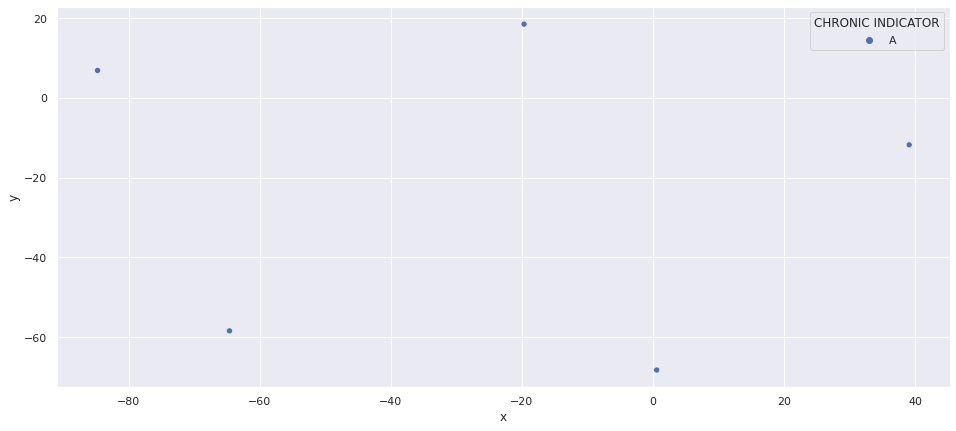

In [17]:
%%time

# tSNE

cci_df = cci_df.head(n=100)

d = pd.DataFrame(aaa)
logger.info(d.head())
logger.info(d.shape)
d = d.fillna(1)
tSNE_result=tSNE.fit_transform(d)
x=tSNE_result[:,0]
y=tSNE_result[:,1]
cci_df['x']=x
cci_df['y']=y
logger.info(cci_df.head())
plt.figure(figsize=(16,7))
sns.scatterplot(x='x',y='y',data=cci_df, legend="full", hue="CHRONIC INDICATOR")
plt.savefig(f'{output}/tsne.pdf')